In [9]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [3]:
scores = pd.read_csv('all_api_raw_scores.csv')

In [4]:
scores.head(5)

,IBM,Azure,Google,AWS
0,0.760051,0.958107,0.3,0.514261
1,0.908944,0.961736,0.4,0.820620
2,-0.675144,0.500000,0.0,0.946000
3,0.707989,0.500000,0.6,0.710918
4,0.806287,0.500000,0.3,0.572770


In [5]:
labels = pd.read_csv('merged.csv')
labels.head(5)

,text,sentiment
0,"Good day ladies and gentlemen, and welcome to ...",neutral
1,Thank you. Good afternoon everyone and welcome...,neutral
2,G&A expense trends in the third quarter were a...,neutral
3,"To give you a bit of a breakdown, the largest ...",positive
4,"That being said, we do remain very focused on ...",neutral


In [6]:
scores['sentiment'] = labels['sentiment']

In [7]:
scores.to_csv('data_for_automl.csv', index=False)

In [8]:
h2o.init(nthreads = 2, max_mem_size = 12)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from F:\anaconda\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\gaurang\AppData\Local\Temp\tmpchwrmxxz
  JVM stdout: C:\Users\gaurang\AppData\Local\Temp\tmpchwrmxxz\h2o_Gaurang_Davda_started_from_python.out
  JVM stderr: C:\Users\gaurang\AppData\Local\Temp\tmpchwrmxxz\h2o_Gaurang_Davda_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.9
H2O cluster version age:,1 month and 28 days
H2O cluster name:,H2O_from_python_Gaurang_Davda_36ydgm
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [10]:
data = h2o.import_file('data_for_automl.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [11]:
splits = data.split_frame(ratios=[0.8], seed=1)
train = splits[0]
test = splits[1]

In [12]:
aml = H2OAutoML(max_runtime_secs=600, seed = 1, project_name = "Sentiment generalization")
aml.train(y = 'sentiment', training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [13]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
GBM_grid_0_AutoML_20181130_030545_model_0,0.522396,0.893097,0.548703,0.301076
DeepLearning_grid_0_AutoML_20181130_030545_model_1,0.52817,1.3272,0.594406,0.353319
DeepLearning_grid_0_AutoML_20181130_030545_model_4,0.534974,1.54378,0.601865,0.362241
DRF_0_AutoML_20181130_030545,0.538756,2.66048,0.563078,0.317057
DeepLearning_grid_0_AutoML_20181130_030545_model_0,0.545096,1.03317,0.564589,0.318761
GBM_grid_0_AutoML_20181130_030545_model_2,0.549248,0.884855,0.553066,0.305882
XRT_0_AutoML_20181130_030545,0.557479,2.48489,0.558894,0.312363
GBM_grid_0_AutoML_20181130_030545_model_1,0.558117,0.889837,0.55559,0.308681
GBM_grid_0_AutoML_20181130_030545_model_6,0.558733,0.998903,0.630179,0.397126
GBM_grid_0_AutoML_20181130_030545_model_3,0.570582,0.892059,0.556443,0.309629


In [14]:
pred = aml.predict(test)
pred.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,negative,neutral,positive
positive,0.0930294,0.358858,0.548112
positive,0.0257354,0.34307,0.631194
positive,0.0246178,0.143438,0.831944
neutral,0.0440684,0.576765,0.379166
positive,0.0212467,0.16071,0.818043
neutral,0.0653325,0.62122,0.313448
positive,0.106849,0.321905,0.571245
positive,0.0129241,0.0968371,0.890239
positive,0.0137731,0.0480035,0.938223
neutral,0.135756,0.678447,0.185797


In [15]:
perf = aml.leader.model_performance(test)
perf


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.34388680938518484
RMSE: 0.5864186298073969
LogLoss: 0.9986286904558155
Mean Per-Class Error: 0.5791666666666667
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



negative,neutral,positive,Error,Rate
1.0,7.0,8.0,0.9375,15 / 16
0.0,24.0,21.0,0.4666667,21 / 45
3.0,20.0,46.0,0.3333333,23 / 69
4.0,51.0,75.0,0.4538462,59 / 130


Top-3 Hit Ratios: 


k,hit_ratio
1,0.5461538
2,0.8846154
3,1.0


In [16]:
perf.confusion_matrix()

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



negative,neutral,positive,Error,Rate
1.0,7.0,8.0,0.9375,15 / 16
0.0,24.0,21.0,0.4666667,21 / 45
3.0,20.0,46.0,0.3333333,23 / 69
4.0,51.0,75.0,0.4538462,59 / 130


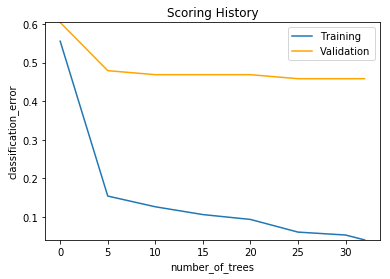

In [19]:
aml.leader.plot()

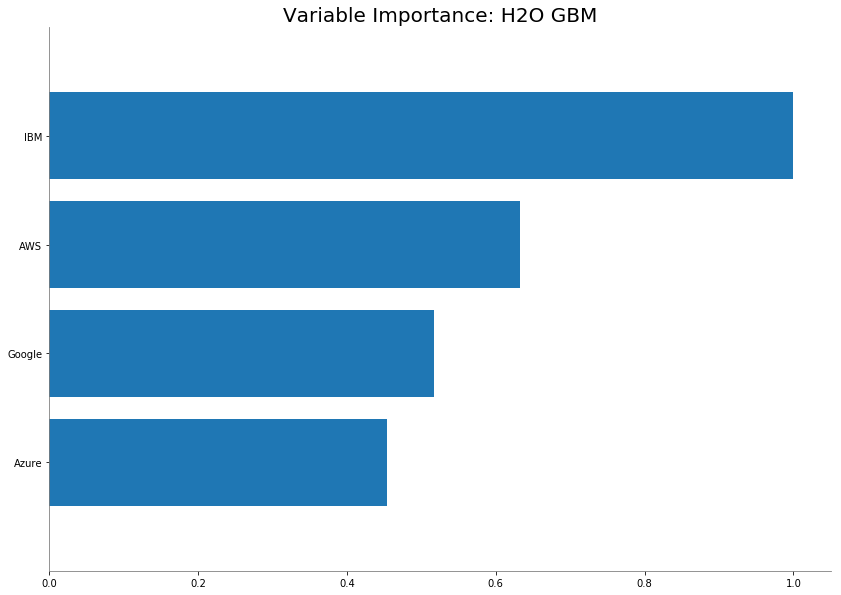

In [18]:
aml.leader.varimp_plot()

In [33]:
sklearn.metrics.precision_score(test['sentiment'].as_data_frame(), pred['predict'].as_data_frame(), average='weighted')

0.5192036199095021

In [34]:
sklearn.metrics.recall_score(test['sentiment'].as_data_frame(), pred['predict'].as_data_frame(), average='weighted')

0.5461538461538461

In [35]:
sklearn.metrics.accuracy_score(test['sentiment'].as_data_frame(), pred['predict'].as_data_frame())

0.5461538461538461

In [36]:
splitsv = data.split_frame(ratios=[0.7, 0.15], seed=1)
trainv = splitsv[0]
val = splitsv[1]
testv = splitsv[2]
deep = H2ODeepLearningEstimator(model_id='deep', epochs=100, hidden=[50,100])
# The use of a validation_frame is recommended with using early stopping
deep.train(x=['IBM', 'Azure', 'Google', 'AWS'], y='sentiment', training_frame=trainv, validation_frame=val)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [37]:
deep_perf = deep.model_performance(testv)
deep_perf


ModelMetricsMultinomial: deeplearning
** Reported on test data. **

MSE: 0.38027575488738363
RMSE: 0.6166650264830847
LogLoss: 1.2378632495413835
Mean Per-Class Error: 0.6307277628032345
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



negative,neutral,positive,Error,Rate
1.0,0.0,6.0,0.8571429,6 / 7
5.0,10.0,20.0,0.7142857,25 / 35
9.0,8.0,36.0,0.3207547,17 / 53
15.0,18.0,62.0,0.5052632,48 / 95


Top-3 Hit Ratios: 


k,hit_ratio
1,0.4947369
2,0.8315790
3,1.0


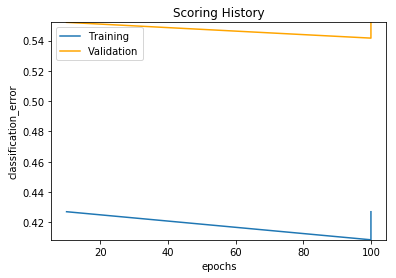

In [38]:
deep.plot()

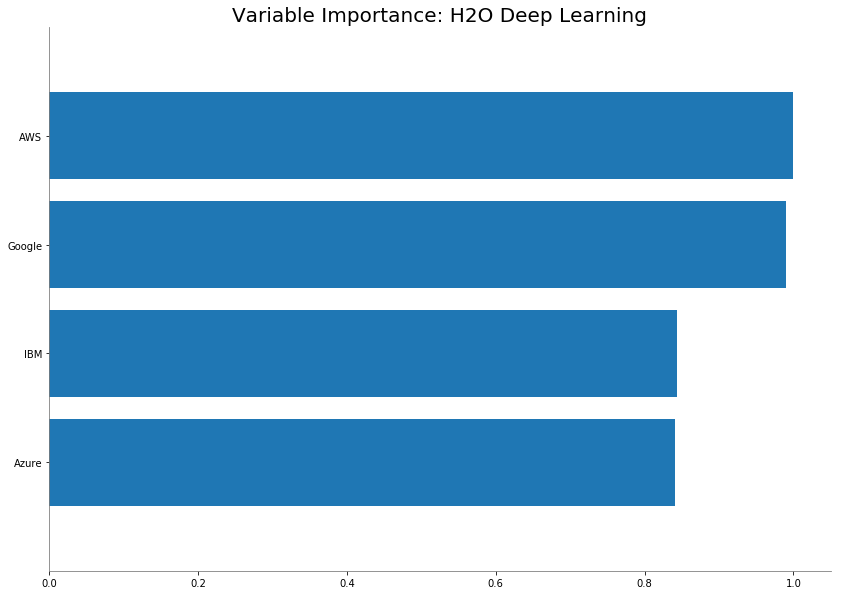

In [39]:
deep.varimp_plot()

In [43]:
deep_pred = deep.predict(testv)
deep_pred

deeplearning prediction progress: |███████████████████████████████████████| 100%


predict,negative,neutral,positive
positive,0.0232155,0.374134,0.60265
positive,9.46692e-05,0.0833983,0.916507
positive,0.0264043,0.388179,0.585417
positive,0.0497186,0.105655,0.844626
positive,0.374381,0.0600514,0.565567
positive,8.81471e-05,0.152271,0.847641
positive,1.03222e-05,0.0619493,0.93804
negative,0.83326,0.0371965,0.129544
positive,0.000824735,0.161555,0.83762
negative,0.581795,0.0190626,0.399143


In [41]:
deep_perf.confusion_matrix()

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



negative,neutral,positive,Error,Rate
1.0,0.0,6.0,0.8571429,6 / 7
5.0,10.0,20.0,0.7142857,25 / 35
9.0,8.0,36.0,0.3207547,17 / 53
15.0,18.0,62.0,0.5052632,48 / 95


In [44]:
sklearn.metrics.precision_score(testv['sentiment'].as_data_frame(), deep_pred['predict'].as_data_frame(), average='weighted')

0.5335295227315602

In [45]:
sklearn.metrics.recall_score(testv['sentiment'].as_data_frame(), deep_pred['predict'].as_data_frame(), average='weighted')

0.49473684210526314

In [46]:
sklearn.metrics.accuracy_score(testv['sentiment'].as_data_frame(), deep_pred['predict'].as_data_frame())

0.49473684210526314